In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import wind_power_bidding as wpb

In [2]:
# Set figure style
plt.style.use('seaborn-v0_8-paper')

tex_fonts = {
# Use LaTeX to write all text
"text.usetex": True,
"font.family": "serif",
# Use 10pt font in plots, to match 10pt font in document
"axes.labelsize": 18,
"font.size": 18,
"axes.titlesize": 18,   
# Make the legend/label fonts a little smaller
"legend.fontsize": 16,
"xtick.labelsize": 16,
"ytick.labelsize": 16
}
plt.rcParams.update(tex_fonts)

In [3]:
# Load the forecast data
with open('InputData/Scenarios.pkl', 'rb') as file:
    data = pickle.load(file)
wind_forecast = data['wind_data_da']
spot_forecast = data['spot_prices']
# spot_forecast = np.ones(np.shape(spot_forecast))
imbalance_forecast = data['imbalance']
n1=20; n2=20; n3=4; n_scenarios = [n1,n2,n3]
print(np.shape(wind_forecast))
print(np.shape(spot_forecast))
print(np.shape(imbalance_forecast))

f_up= 1.25
f_down = 0.85

(24, 20)
(24, 20)
(24, 4)


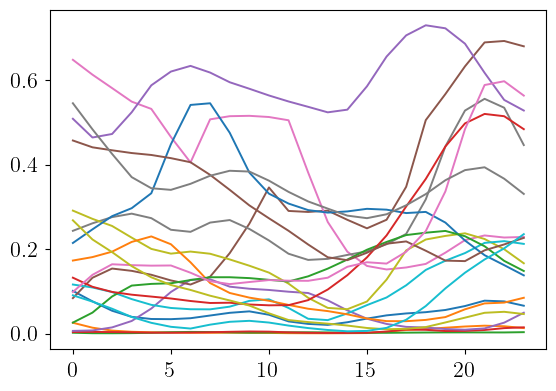

In [4]:
plt.plot(wind_forecast, label='Wind Forecast')

# 1) One price scheme

In [5]:
# combine scenarios and shuffle them 
import itertools

combined_scenarios = list(itertools.product(range(n1), range(n2), range(n3)))
np.random.seed(0)
shuffled_scenarios = np.random.permutation(combined_scenarios)

In [6]:
# nb_scenarios to consider
n_scenarios = 200
scenarios_id = shuffled_scenarios[:n_scenarios, :] # take the first n_scenarios as the in-sample scenarios
wind_bids, prob, imbalances, imbalances_up, imbalances_down= wpb.wind_pp_bidding(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, price_scheme='one_price')

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 16 05:02:35 PM: Your problem has 14424 variables, 28848 constraints, and 0 parameters.


/Users/mjacobs/opt/anaconda3/envs/renewables/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  407.75711740597734


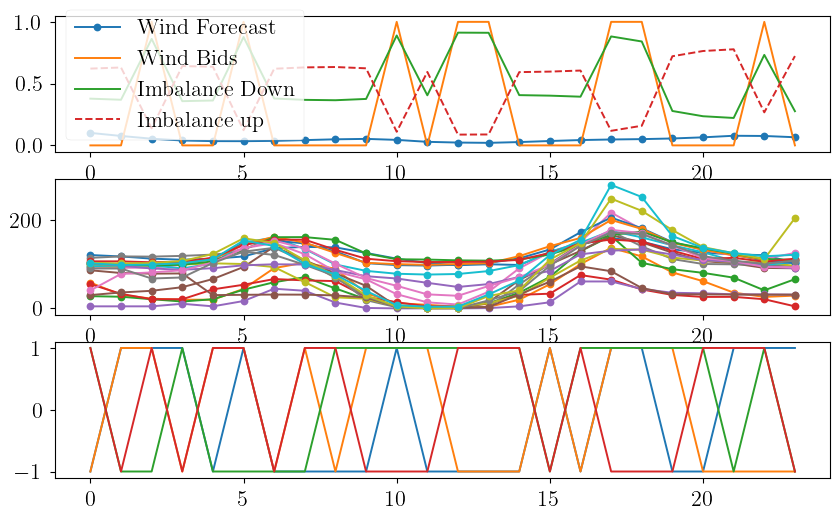

In [7]:
# Visualize the selected wind bids
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.plot(wind_forecast[:,:1], label='Wind Forecast', marker='o')
plt.plot(wind_bids, label='Wind Bids', marker='x')
plt.plot(imbalances_down[:,:1], label='Imbalance Down')
plt.plot(imbalances_up[:,:1], label='Imbalance up', linestyle='--')
plt.legend()
plt.subplot(312)
plt.plot(spot_forecast[:,:n1], label='Spot Prices', marker='o')
plt.subplot(313)
plt.plot(imbalance_forecast[:,:n3], label='Imbalance Prices', marker='x')

Expected Profit:  451.73917685707596


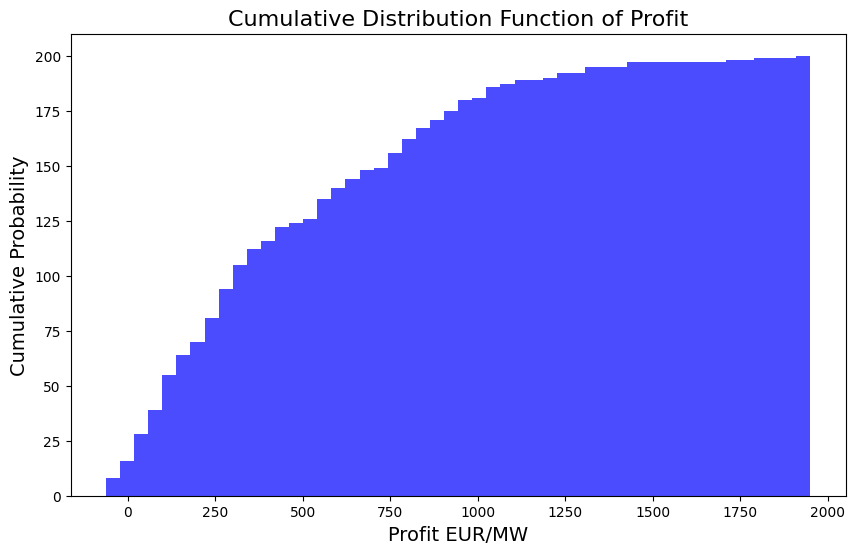

In [7]:
# compute profit of in-sample scenarios
# Compute the profit over all scenarios
profit = np.zeros((n_scenarios, 1))
for i in range(n_scenarios):
        profit[i] = wpb.compute_profit(wind_bids, wind_forecast[:, scenarios_id[i, 0]], spot_forecast[:,scenarios_id[i, 1]], imbalance_forecast[:, scenarios_id[i, 2]], f_down, f_up, 'one_price')

# flatten profit array
profit_flat = profit.flatten()
# Sort the profit array
profit_sorted = np.sort(profit_flat)
# Compute the expected profit
expected_profit = np.mean(profit_sorted)
print("Expected Profit: ", expected_profit)
# Visualize the cumulative distribution function (CDF)
plt.figure(figsize=(10, 6))
plt.hist(profit_sorted, bins=50, cumulative=True, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of Profit', fontsize=16)
plt.xlabel('Profit EUR/MW', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.savefig('figs/1price_profit_cdf.png')

# 2) Two-price scheme

<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/var/folders/_w/7vf8rztn4831jvpw7bvxy9_h0000gp/T/ipykernel_64506/1592326998.py:5: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Wind Power [\% of rated capacity]')


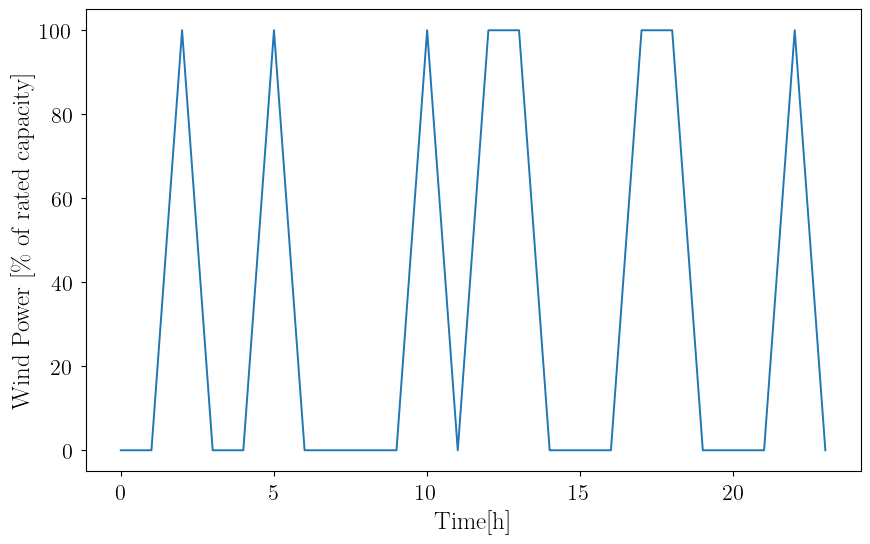

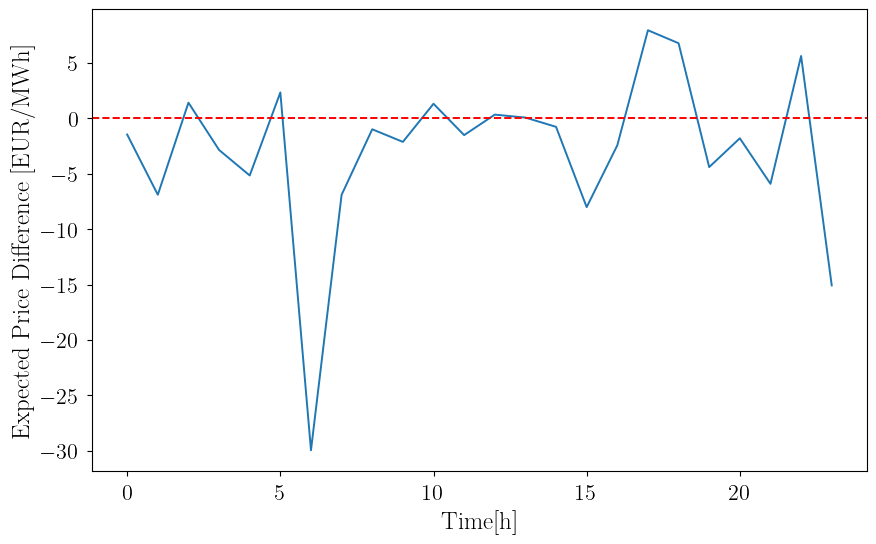

In [8]:
# Report plots
plt.figure(figsize=(10, 6))
plt.plot(100*wind_bids, label='Wind Bids', marker='x')
plt.xlabel('Time[h]')
plt.ylabel('Wind Power [\% of rated capacity]')
plt.savefig('Figures/wind_bids.pdf')

# Check difference between average imbalance price and average day-ahead price for each timestep
delta = (1- np.maximum(imbalance_forecast[:, scenarios_id[:, 2]],0)*f_down + np.minimum(imbalance_forecast[:, scenarios_id[:, 2]],0)*f_up)*spot_forecast[:, scenarios_id[:, 1]] 
delta_avg = np.mean(delta,axis=1)
plt.figure(figsize=(10, 6))
plt.plot(delta_avg, marker='x')
# Plot dotted horizontal line at 0
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time[h]')
plt.ylabel('Expected Price Difference [EUR/MWh]')
plt.savefig('Figures/expected_price_delta.pdf')

Expected Profit:  407.75711740597745


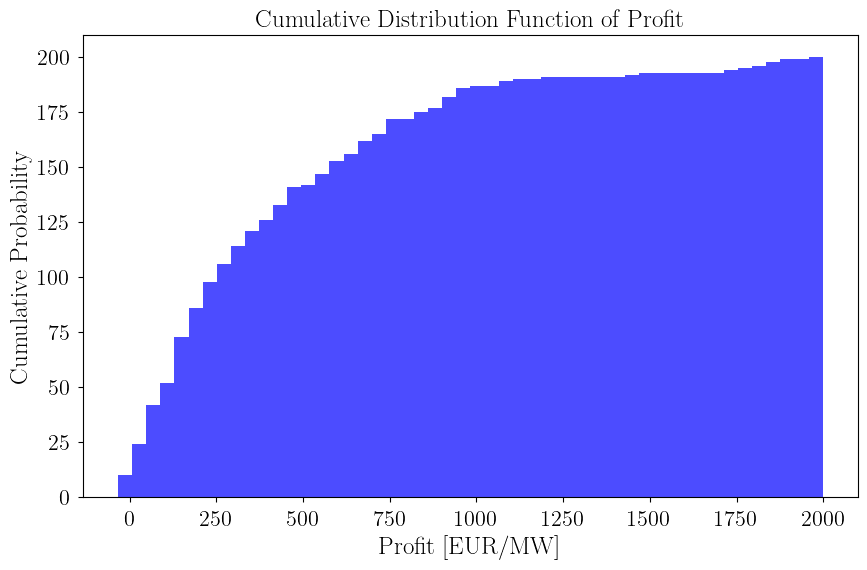

In [9]:
# compute profit of in-sample scenarios
# Compute the profit over all scenarios
profit = np.zeros((n_scenarios, 1))
for i in range(n_scenarios):
        profit[i] = wpb.compute_profit(wind_bids, wind_forecast[:, scenarios_id[i, 0]], spot_forecast[:,scenarios_id[i, 1]], imbalance_forecast[:, scenarios_id[i, 2]], f_down, f_up, 'one_price')

# flatten profit array
profit_flat = profit.flatten()
# Sort the profit array
profit_sorted = np.sort(profit_flat)
# Compute the expected profit
expected_profit = np.mean(profit_sorted)
print("Expected Profit: ", expected_profit)
# Visualize the cumulative distribution function (CDF)
plt.figure(figsize=(10, 6))
plt.hist(profit_sorted, bins=50, cumulative=True, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of Profit')
plt.xlabel('Profit [EUR/MW]')
plt.ylabel('Cumulative Probability')
plt.savefig('Figures/1p_profit_cdf.pdf')

# 2) Two-price scheme

In [10]:
wind_bids, prob, imbalances, imbalances_up, imbalances_down= wpb.wind_pp_bidding(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, price_scheme='two_price')

Objective value:  347.23372464940996


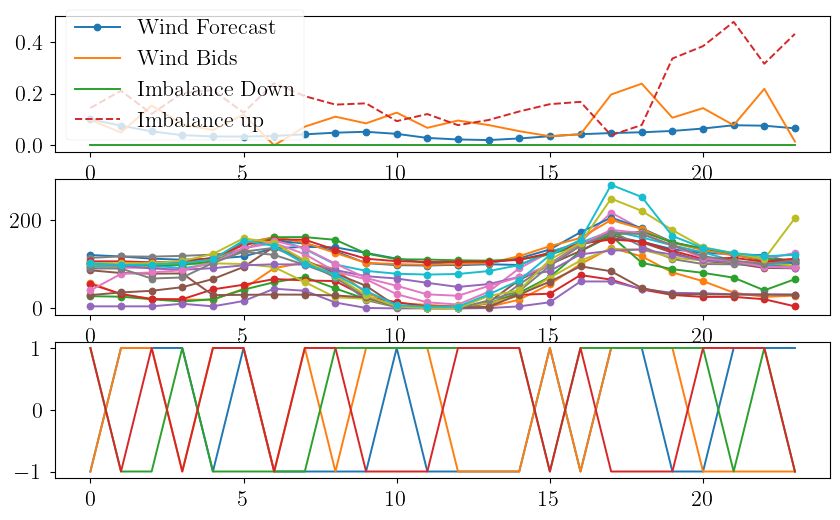

In [11]:
# Visualize the selected wind bids
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.plot(wind_forecast[:,:1], label='Wind Forecast', marker='o')
plt.plot(wind_bids, label='Wind Bids', marker='x')
plt.plot(imbalances_down[:,:1], label='Imbalance Down')
plt.plot(imbalances_up[:,:1], label='Imbalance up', linestyle='--')
plt.legend()
plt.subplot(312)
plt.plot(spot_forecast[:,:n1], label='Spot Prices', marker='o')
plt.subplot(313)
plt.plot(imbalance_forecast[:,:n3], label='Imbalance Prices', marker='x')

<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/var/folders/_w/7vf8rztn4831jvpw7bvxy9_h0000gp/T/ipykernel_64506/3022296304.py:5: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Wind Power [\% of rated capacity]')


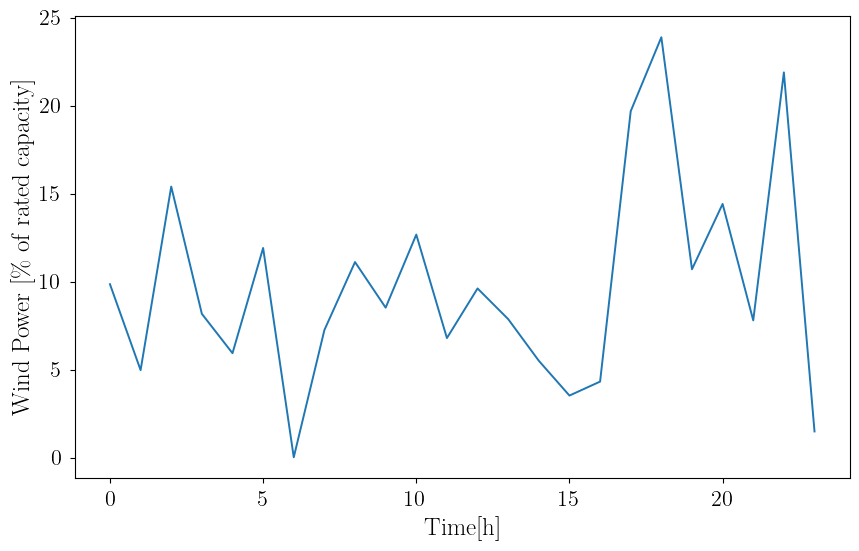

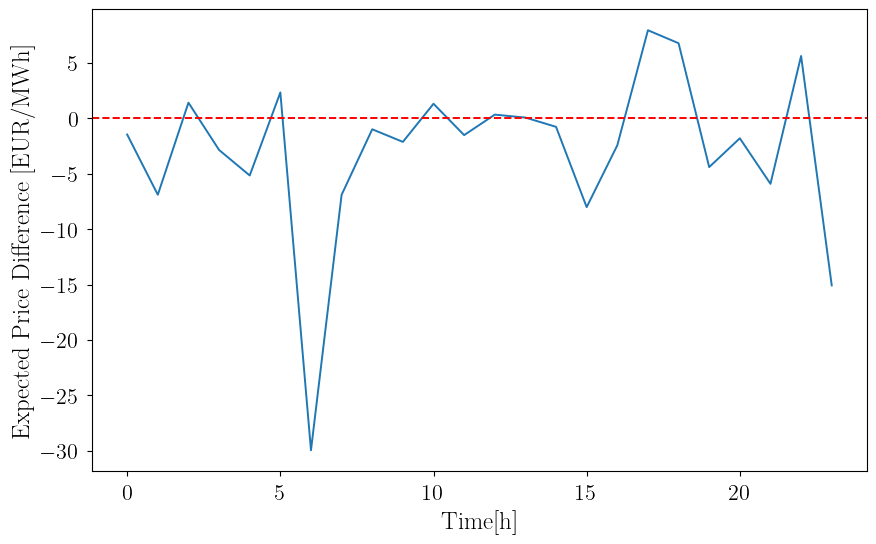

In [12]:
# Report plots
plt.figure(figsize=(10, 6))
plt.plot(100*wind_bids, label='Wind Bids', marker='x')
plt.xlabel('Time[h]')
plt.ylabel('Wind Power [\% of rated capacity]')
plt.savefig('Figures/wind_bids_2p.pdf')

# Check difference between average imbalance price and average day-ahead price for each timestep
delta = (1- np.maximum(imbalance_forecast[:, scenarios_id[:, 2]],0)*f_down + np.minimum(imbalance_forecast[:, scenarios_id[:, 2]],0)*f_up)*spot_forecast[:, scenarios_id[:, 1]] 
delta_avg = np.mean(delta,axis=1)
plt.figure(figsize=(10, 6))
plt.plot(delta_avg, marker='x')
# Plot dotted horizontal line at 0
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time[h]')
plt.ylabel('Expected Price Difference [EUR/MWh]')
plt.savefig('Figures/expected_price_delta.pdf')

Expected Profit:  383.35406927182544


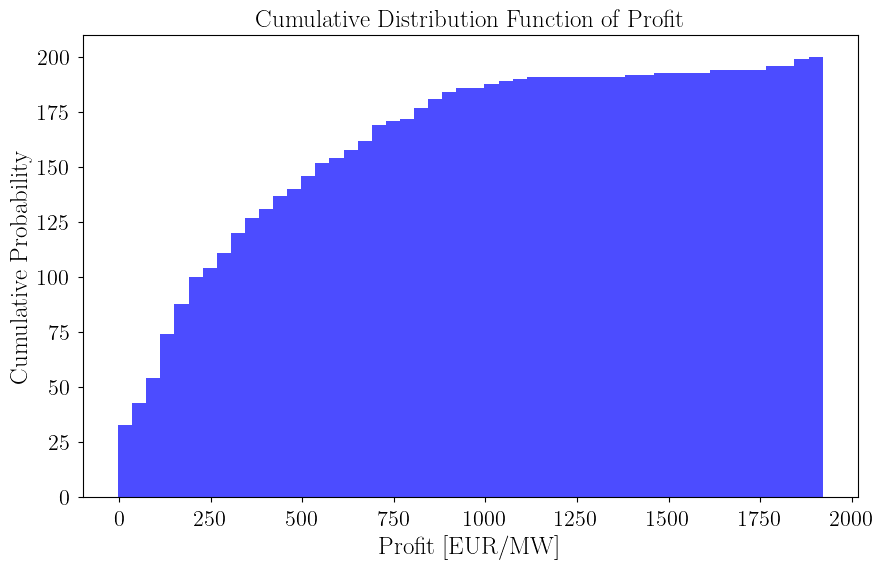

In [13]:
# compute profit of in-sample scenarios
# Compute the profit over all scenarios
profit = np.zeros((n_scenarios, 1))
for i in range(n_scenarios):
        profit[i] = wpb.compute_profit(wind_bids, wind_forecast[:, scenarios_id[i, 0]], spot_forecast[:,scenarios_id[i, 1]], imbalance_forecast[:, scenarios_id[i, 2]], f_down, f_up, 'one_price')

# flatten profit array
profit_flat = profit.flatten()
# Sort the profit array
profit_sorted = np.sort(profit_flat)
# Compute the expected profit
expected_profit = np.mean(profit_sorted)
print("Expected Profit: ", expected_profit)
# Visualize the cumulative distribution function (CDF)
plt.figure(figsize=(10, 6))
plt.hist(profit_sorted, bins=50, cumulative=True, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of Profit')
plt.xlabel('Profit [EUR/MW]')
plt.ylabel('Cumulative Probability')
plt.savefig('Figures/2p_profit_cdf.pdf')

# 3) Ex-Post analysis

In [14]:
def k_fold_cross_validation(wind_forecast, spot_forecast, imbalance_forecast, shuffled_scenarios, f_up, f_down, scheme='one_price', reps=8):

    print("Performing k-fold cross-validation with {} folds...".format(reps))
    print("Price scheme: ", scheme)
    fold_size = len(shuffled_scenarios) // reps # should assert divisibility
    expected_in_profits = np.zeros((reps, 1))
    expected_out_profits = np.zeros((reps, 1))
    in_profits = np.zeros((reps, fold_size))
    out_profits = np.zeros((reps, len(shuffled_scenarios)-fold_size))
    for k in range(reps):
        in_sample_scenarios = shuffled_scenarios[k*fold_size:(k+1)*fold_size, :] # since we shuffled scenarios, we can just take the fold_size scenarios from k*fold_size onwards
        out_sample_scenarios = np.delete(shuffled_scenarios, np.s_[k*fold_size:(k+1)*fold_size], axis=0) # delete in-sample scenarios from the shuffled scenarios

        # compute wind bids, only use in-sample scenarios
        wind_bids, _, _, _, _= wpb.wind_pp_bidding(wind_forecast[:, in_sample_scenarios[:, 0]], spot_forecast[:, in_sample_scenarios[:, 1]], imbalance_forecast[:, in_sample_scenarios[:, 2]], f_up, f_down, price_scheme=scheme)
        
        # compute profits 
        profits_in_sample = np.zeros((len(in_sample_scenarios), 1))
        for i in range(len(in_sample_scenarios)):
            # compute profits for in-sample scenarios
            profits_in_sample[i] = wpb.compute_profit(wind_bids, wind_forecast[:, in_sample_scenarios[i, 0]], spot_forecast[:, in_sample_scenarios[i, 1]], imbalance_forecast[:, in_sample_scenarios[i, 2]], f_down, f_up, scheme)
        profits_out_sample = np.zeros((len(out_sample_scenarios), 1))
        
        for i in range(len(out_sample_scenarios)):
            # compute profits for out-of-sample scenarios
            profits_out_sample[i] = wpb.compute_profit(wind_bids, wind_forecast[:, out_sample_scenarios[i, 0]], spot_forecast[:, out_sample_scenarios[i, 1]], imbalance_forecast[:, out_sample_scenarios[i, 2]], f_down, f_up, scheme)
        
        expected_in_profits[k] = np.mean(profits_in_sample)
        in_profits[k,:] = profits_in_sample.flatten()
        expected_out_profits[k] = np.mean(profits_out_sample)
        out_profits[k,:] = profits_out_sample.flatten()

    return expected_in_profits, expected_out_profits, in_profits, out_profits

## One Price

In [43]:
expected_in_profits, expected_out_profits, in_profits, out_profits = k_fold_cross_validation(wind_forecast, spot_forecast, imbalance_forecast, shuffled_scenarios, f_up, f_down, scheme='one_price', reps=8)

Performing k-fold cross-validation with 8 folds...
Price scheme:  one_price


/Users/mjacobs/opt/anaconda3/envs/renewables/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  449.7084044316386
Objective value:  497.0341945485431
Objective value:  435.3612529360478
Objective value:  430.45623721210023
Objective value:  478.1954349897936
Objective value:  416.23076817872413
Objective value:  420.85938786797516
Objective value:  477.45223337966337


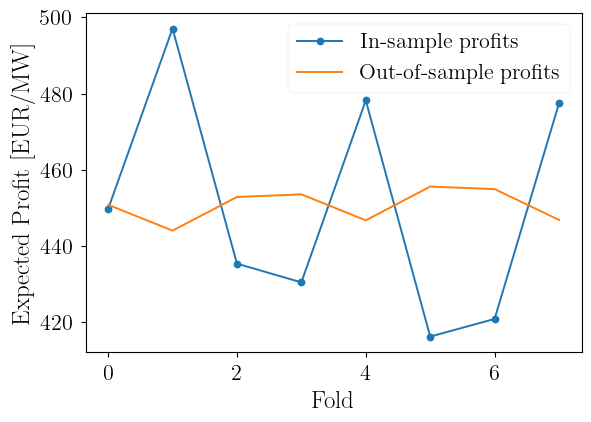

In [44]:
plt.plot(expected_in_profits, label='In-sample profits', marker='o')
plt.plot(expected_out_profits, label='Out-of-sample profits', marker='x')
plt.xlabel('Fold')
plt.ylabel('Expected Profit [EUR/MW]')
plt.legend()
plt.savefig('Figures/1p_expected_profits.pdf')




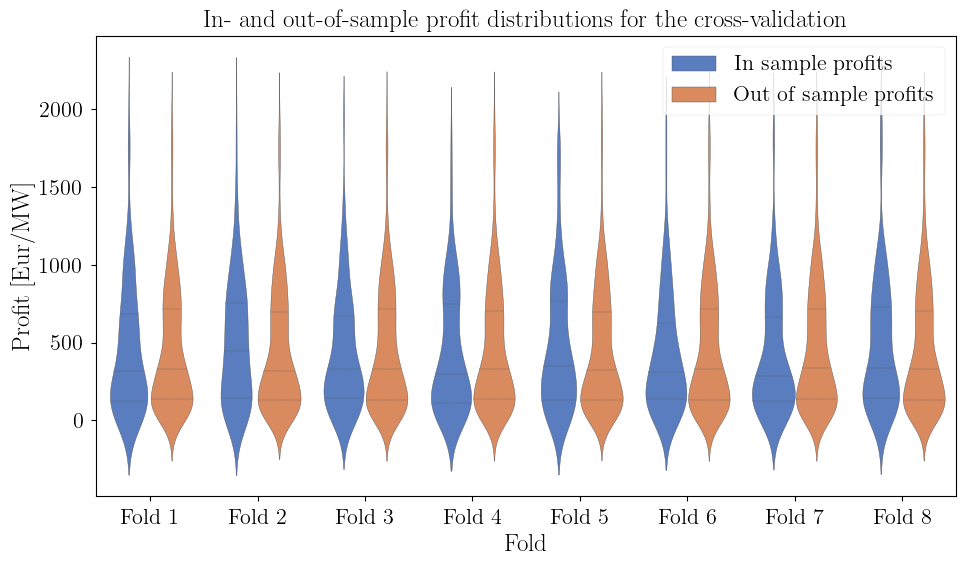

In [46]:
import pandas as pd
import seaborn as sns
n_folds = np.shape(in_profits)[0]

# Prepare data in long-form for seaborn
all_data = []
for i in range(n_folds):
    all_data.append(pd.DataFrame({
        "Profit [Eur/MW]": in_profits[i,:],
        "Fold": f"Fold {i+1}",
        "Set": "In sample profits"
    }))
    all_data.append(pd.DataFrame({
        "Profit [Eur/MW]": out_profits[i,:],
        "Fold": f"Fold {i+1}",
        "Set": "Out of sample profits"
    }))

df = pd.concat(all_data)

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="Fold", y="Profit [Eur/MW]", hue="Set", split=False, inner="quart", palette="muted")
plt.legend(loc='upper right')
plt.title("In- and out-of-sample profit distributions for the cross-validation")
plt.tight_layout()
plt.savefig('Figures/1p_crossval.pdf')


## Two-Price

In [34]:
expected_in_profits, expected_out_profits, in_profits, out_profits = k_fold_cross_validation(wind_forecast, spot_forecast, imbalance_forecast, shuffled_scenarios, f_up, f_down, 'two_price', 8)

Performing k-fold cross-validation with 8 folds...
Price scheme:  two_price


/Users/mjacobs/opt/anaconda3/envs/renewables/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  377.62336971078554
Objective value:  427.8894246601106
Objective value:  366.2877918550673
Objective value:  360.3900185048994
Objective value:  402.9920071124723
Objective value:  352.6764489673185
Objective value:  357.8641260365028
Objective value:  406.63151474024846


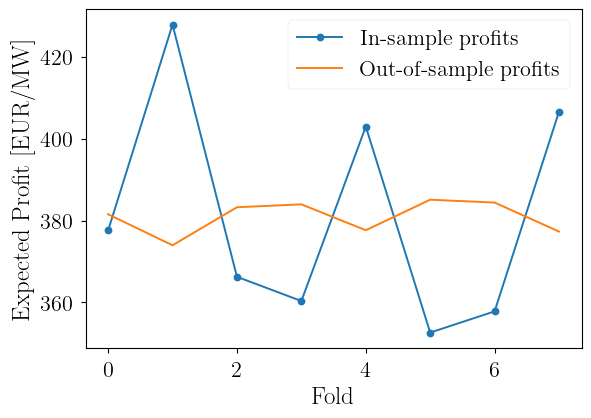

In [42]:
plt.plot(expected_in_profits, label='In-sample profits', marker='o')
plt.plot(expected_out_profits, label='Out-of-sample profits', marker='x')
plt.xlabel('Fold')
plt.ylabel('Expected Profit [EUR/MW]')
plt.legend()
plt.savefig('Figures/2p_expected_profits.pdf')

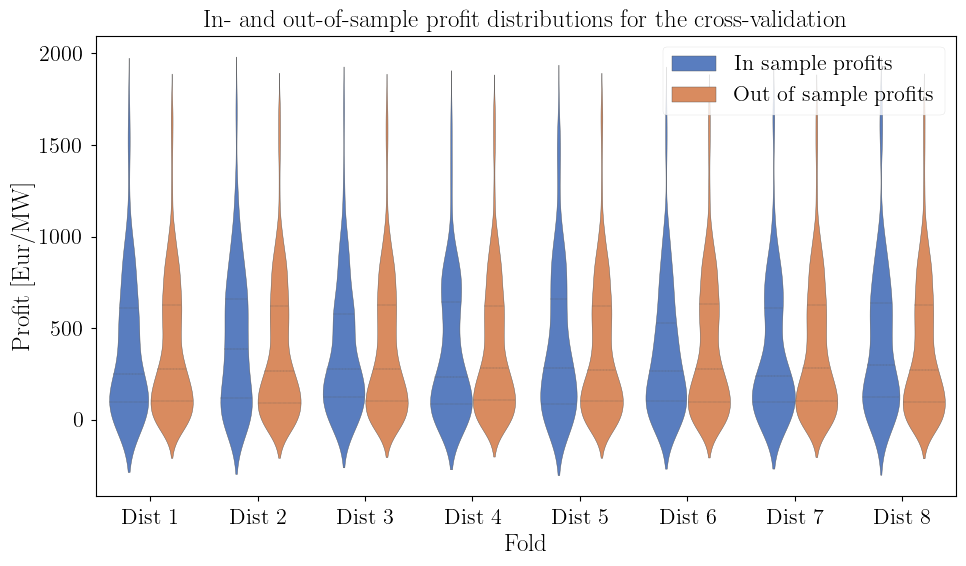

In [40]:
n_folds = np.shape(in_profits)[0]

# Prepare data in long-form for seaborn
all_data = []
for i in range(n_folds):
    all_data.append(pd.DataFrame({
        "Profit [Eur/MW]": in_profits[i,:],
        "Fold": f"Fold {i+1}",
        "Set": "In sample profits"
    }))
    all_data.append(pd.DataFrame({
        "Profit [Eur/MW]": out_profits[i,:],
        "Fold": f"Fold {i+1}",
        "Set": "Out of sample profits"
    }))

df = pd.concat(all_data)

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="Fold", y="Profit [Eur/MW]", hue="Set", split=False, inner="quart", palette="muted")
plt.legend(loc='upper right')
plt.title("In- and out-of-sample profit distributions for the cross-validation")
plt.tight_layout()
plt.savefig('Figures/2p_crossval.pdf')


# 4) Risk adverse bidding strategy

In [21]:
# nb_scenarios to consider
n_scenarios = 200
scenarios_id = shuffled_scenarios[:n_scenarios, :] # take the first n_scenarios as the in-sample scenarios

In [22]:
scheme = 'one_price'
wind_bids_ra, prob_ra, imbalances_ra, imbalances_up_ra, imbalances_down_ra, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.90, beta = 0, price_scheme=scheme)
# check : with beta = 0, the results should be the same as the previous res for selected price scheme
# NOTE: we chose the (1-beta)*p + beta*cvar objective, so 0<=beta<=1

Objective value:  407.7571173951947


In [23]:
cvar, expected_profit

(-36.1586268372932, 407.7571173951947)

In [24]:
wind_bids_ra, prob_ra, imbalances_ra, imbalances_up_ra, imbalances_down_ra, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.90, beta = 0.95, price_scheme=scheme)

Objective value:  42.22066077260436


In [25]:
cvar, expected_profit

(23.16950624903105, 404.192596720497)

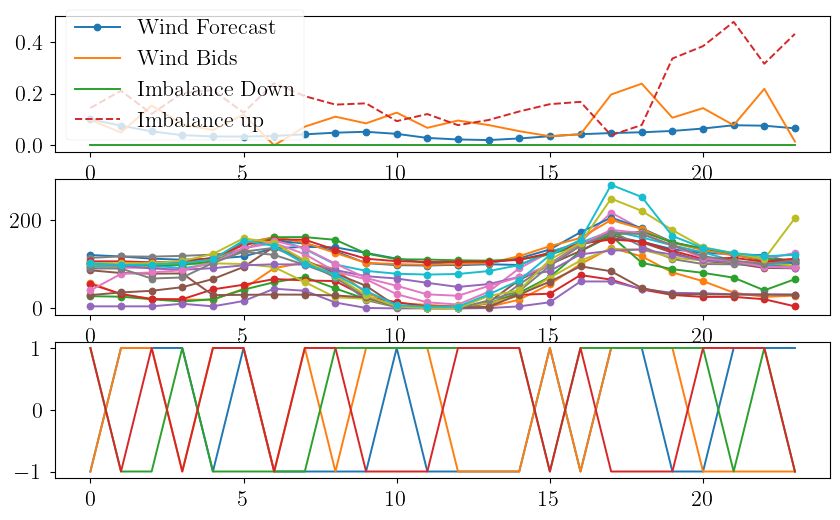

In [26]:
# Visualize the selected wind bids
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.plot(wind_forecast[:,:1], label='Wind Forecast', marker='o')
plt.plot(wind_bids, label='Wind Bids', marker='x')
plt.plot(imbalances_down[:,:1], label='Imbalance Down')
plt.plot(imbalances_up[:,:1], label='Imbalance up', linestyle='--')
plt.legend()
plt.subplot(312)
plt.plot(spot_forecast[:,:n1], label='Spot Prices', marker='o')
plt.subplot(313)
plt.plot(imbalance_forecast[:,:n3], label='Imbalance Prices', marker='x')

Expected Profit:  383.35406927182544


Text(0.5, 1.0, 'Cumulative Distribution Function of Profit')

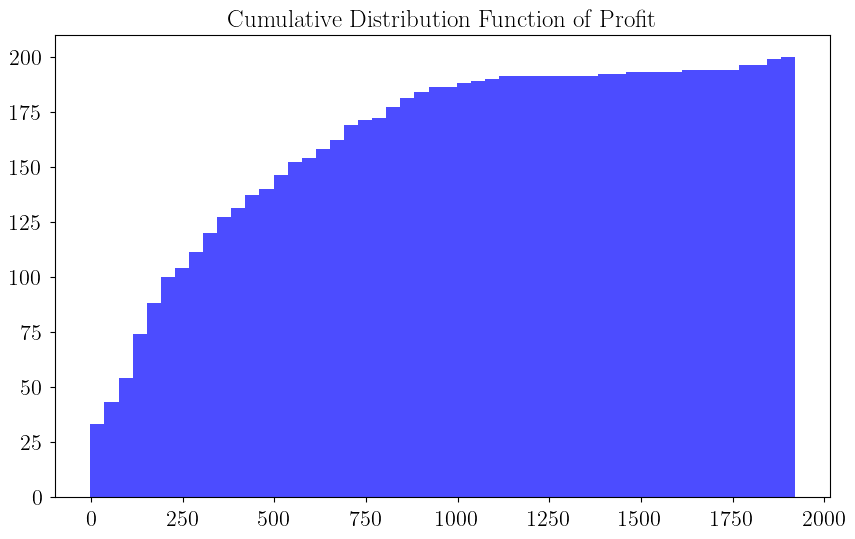

In [27]:
# compute profit of in-sample scenarios
# Compute the profit over all scenarios
profit = np.zeros((n_scenarios, 1))
for i in range(n_scenarios):
        profit[i] = wpb.compute_profit(wind_bids, wind_forecast[:, scenarios_id[i, 0]], spot_forecast[:,scenarios_id[i, 1]], imbalance_forecast[:, scenarios_id[i, 2]], f_down, f_up, scheme)

# flatten profit array
profit_flat = profit.flatten()
# Sort the profit array
profit_sorted = np.sort(profit_flat)
# Compute the expected profit
expected_profit = np.mean(profit_sorted)
print("Expected Profit: ", expected_profit)
# Visualize the cumulative distribution function (CDF)
plt.figure(figsize=(10, 6))
plt.hist(profit_sorted, bins=50, cumulative=True, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of Profit, with risk-averse strategy', fontsize=16)
plt.xlabel('Profit (EUR/MW)', fontsize=14)
plt.ylabel('Cumulated occurences', fontsize=14)
plt.savefig('figs/ra_ecdf_{}.png'.format(scheme), dpi=300)

In [28]:
# pareto frontier
n_points = 10
betas = np.linspace(0, 1-1/n_points, n_points)
exp_profs, cvars = list(), list()

for beta in betas:
    print("beta: ", beta)
    _, _, _, _, _, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.9, beta=beta, price_scheme=scheme)
    exp_profs.append(expected_profit)
    cvars.append(cvar)

beta:  0.0
Objective value:  407.7571173951947
beta:  0.1
Objective value:  366.23799945431625
beta:  0.2
Objective value:  326.1390829613157
beta:  0.30000000000000004
Objective value:  286.66530597629276
beta:  0.4
Objective value:  247.31483180712473
beta:  0.5
Objective value:  208.12533969548332
beta:  0.6000000000000001
Objective value:  169.12319559292015
beta:  0.7000000000000001
Objective value:  130.13060234731262
beta:  0.8
Objective value:  91.19708316017017
beta:  0.9
Objective value:  52.472532469606215


In [29]:
betas

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

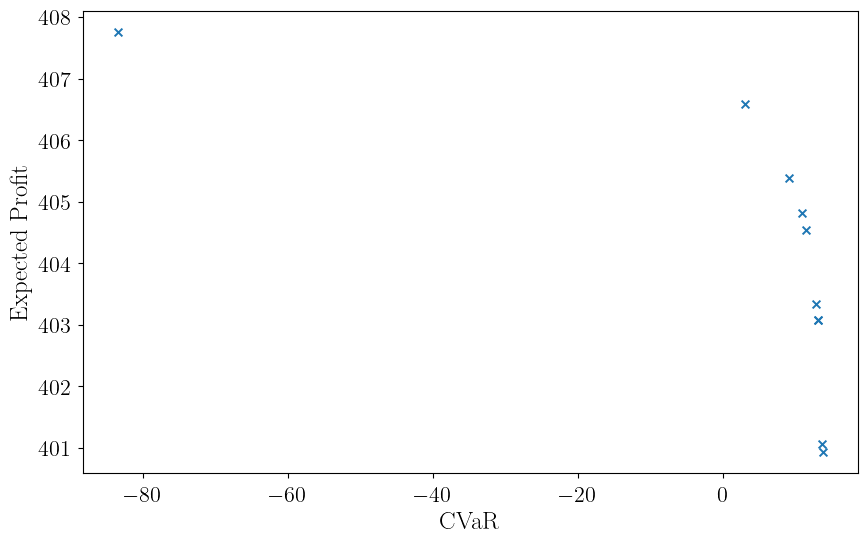

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(cvars, exp_profs, label='Pareto Frontier, for 10 linearly-spaced values β', marker='x')
plt.title('Pareto Frontier, for 10 linearly-spaced values β', fontsize=16)
plt.xlabel('CVaR (EUR/MW)', fontsize=14)
plt.ylabel('Expected Profit (EUR/MW)', fontsize=14)
plt.savefig('figs/ra_pareto_{}.png'.format(scheme), dpi=300)

In [30]:
# study volatility with scenarios
# first increase amount of scenarios
nbs = np.linspace(10, 500, 10, dtype=int)
beta = 0.7 # according to efficiency frontier, with high risk-aversion 
xpected_profits_nbs, cvars_nbs = list(), list()

for nb in nbs:
    scenarios_id = shuffled_scenarios[:nb, :] # take the first n_scenarios as the in-sample scenarios
    _, _, _, _, _, expected_profit_nbs, cvar_nbs = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.9, beta=beta, price_scheme=scheme)
    xpected_profits_nbs.append(expected_profit_nbs)
    cvars_nbs.append(cvar_nbs)

Objective value:  76.59389944692396


/Users/mjacobs/opt/anaconda3/envs/renewables/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  48.95910422245623
Objective value:  43.47455981736479
Objective value:  35.03850907858023
Objective value:  33.68746962985434
Objective value:  32.860126942520154
Objective value:  34.275707108045445
Objective value:  32.3843632038879
Objective value:  32.48808014083886
Objective value:  31.237158264111883


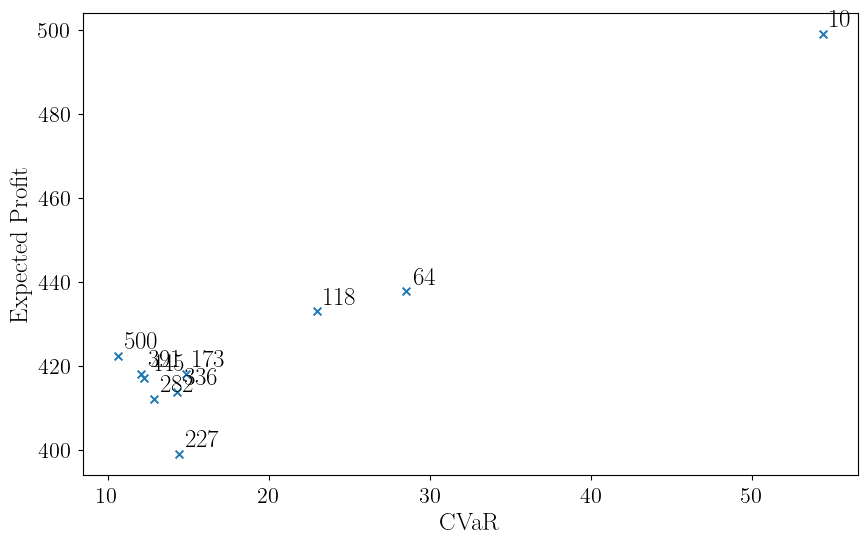

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(cvars, xpected_profits_nbs, label=nbs, marker='x')
plt.xlabel('CVaR')
plt.ylabel('Expected Profit')
# Annotate each point
for i in range(len(cvars)):
    plt.annotate(nbs[i], (cvars[i], xpected_profits_nbs[i]), textcoords="offset points", xytext=(6,0), ha='left', fontsize=6)

plt.xlabel('CVaR (EUR/MW)', fontsize=14)
plt.ylabel('Expected Profit (EUR/MW)', fontsize=14)
plt.title('Expected Profit vs CVaR for different numbers of scenarios', fontsize=16)
plt.savefig('figs/ra_scenarios_{}.png'.format(scheme), dpi=300)

In [32]:
# select sufficient amt of scenarios for cvar not to be volatile (using previous figure)
# now shuffle scenarios randomly and solve bidding problem
nsc = 300
n_shuffles = 10
xpected_profits, cvars = list(), list()

for i in range(n_shuffles):
    shuffled_scenarios = np.random.permutation(combined_scenarios)
    scenarios_id = shuffled_scenarios[:nsc, :] # take the first n_scenarios as the in-sample scenarios
    _, _, _, _, _, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.9, beta=beta, price_scheme=scheme)
    xpected_profits.append(expected_profit)
    cvars.append(cvar)

/Users/mjacobs/opt/anaconda3/envs/renewables/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  38.2969367641889
Objective value:  31.34837682976934
Objective value:  34.84297073096043
Objective value:  38.9290817683225
Objective value:  43.702467815511
Objective value:  36.004857709653166
Objective value:  38.98490583702725
Objective value:  32.29550980993804
Objective value:  33.74113532219531
Objective value:  32.28225736939537


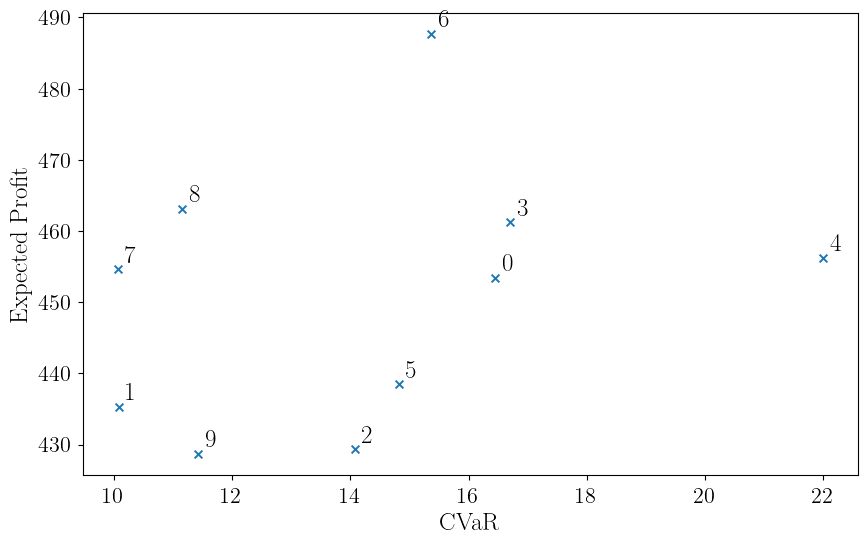

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(cvars, xpected_profits, label=nbs, marker='x')
plt.xlabel('CVaR')
plt.ylabel('Expected Profit')
# Annotate each point
for i in range(len(cvars)):
    plt.annotate(range(n_shuffles)[i], (cvars[i], xpected_profits[i]), textcoords="offset points", xytext=(5,5), ha='left')

plt.xlabel('CVaR (EUR/MW)', fontsize=14)
plt.ylabel('Expected Profit (EUR/MW)', fontsize=14)
plt.title('Expected Profit vs CVaR for different sets of 300 scenarios', fontsize=16)
plt.savefig('figs/ra_sets_{}.png'.format(scheme), dpi=300)